In [1]:
from rl_ood import *
from pprint import pprint
from tqdm.notebook import tqdm
path = Path.cwd()



In [2]:
NB_EP_EVAL = 2

TODO

explimer le score en % d'optimalite

integrer le in distrib dans le truc

# OOD environments instantiation

In [3]:
ENV_NAME = ['CartPole-v1', 'Pendulum-v1', 'MountainCar-v0', 'MountainCarContinuous-v0'][0]
path_agent = path / 'Agents' / ENV_NAME

if ENV_NAME == 'CartPole-v1':
    default_values = CARTPOLE_VALUES
    instanciation_function = instanciate_cartpole

elif ENV_NAME == 'Pendulum-v1':
    default_values = PENDULUM_VALUES
    instanciation_function = instanciate_pendulum

elif ENV_NAME == 'MountainCar-v0':
    default_values = MOUNTAIN_CAR_VALUES
    instanciation_function = instanciate_mountain_car

elif ENV_NAME == 'MountainCarContinuous-v0':
    default_values = MOUNTAIN_CAR_VALUES
    instanciation_function = instanciate_mountain_car_continuous

print("Env name:", ENV_NAME)
print("Defalut values:")
pprint(default_values)

Env name: CartPole-v1
Defalut values:
{'Force_magnitude': 10.0,
 'Gravity': 9.8,
 'Length_pole': 0.5,
 'Mass_cart': 1.0,
 'Mass_pole': 0.1}


Each ood config differs from the defaut environment by only one attribute.

In [4]:
values = create_ood_values(default_values)
ood_configs = get_ood_configs(default_values, values)
print("Number of attributes:", len(values.keys()))
print("Number of ood values per attribute:", len(values['Gravity']))


print("Number of OOD configs:", len(ood_configs))

Number of attributes: 5
Number of ood values per attribute: 20
Number of OOD configs: 100


# Evaluate OOD impact

### Original environment

We train an agent on the original environment, and we evaluate its performances

In [5]:
env = instanciation_function(default_values)

agent = A2C.load(path_agent, env=env)
evaluate(env, agent, nb_episodes=1, render=True)
env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


We evaluate this agent on several ood environments. We get the mean and std of the reward over 10 episodes.

In [6]:
ood_env = instanciation_function(ood_configs[-1])
agent = A2C.load(path_agent, env=ood_env)
evaluate(ood_env, agent, render=False, nb_episodes=10)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


(1000.0, 0.0)

### Impact of the ood on the reward

In [7]:
results = {}
std_results = {}

original_env = instanciation_function(default_values)
agent = A2C.load(path_agent, env=original_env)
original_result, original_std_result = evaluate(original_env, agent, render=False, nb_episodes=NB_EP_EVAL)

for config in tqdm(ood_configs):
    if config['change'] not in results:
        results[config['change']] = []
        std_results[config['change']] = []
    
    ood_env = instanciation_function(config)
    agent = A2C.load(path_agent, env=ood_env)
    mean_reward, std_reward = evaluate(ood_env, agent, nb_episodes=NB_EP_EVAL)
    
    results[config['change']].append(mean_reward)
    std_results[config['change']].append(std_reward)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


  0%|          | 0/100 [00:00<?, ?it/s]

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

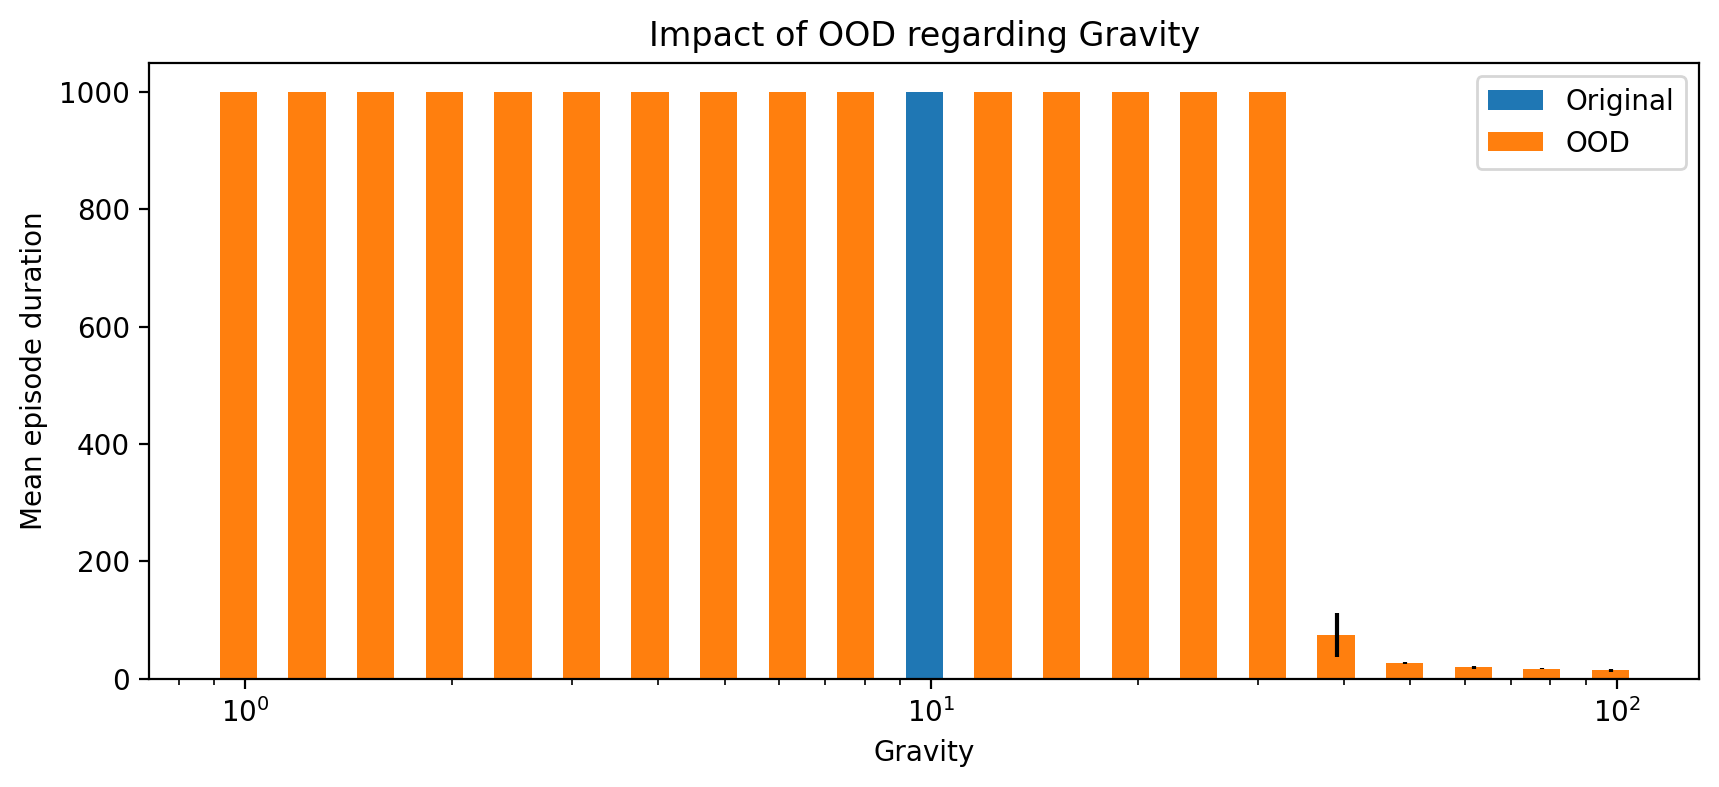

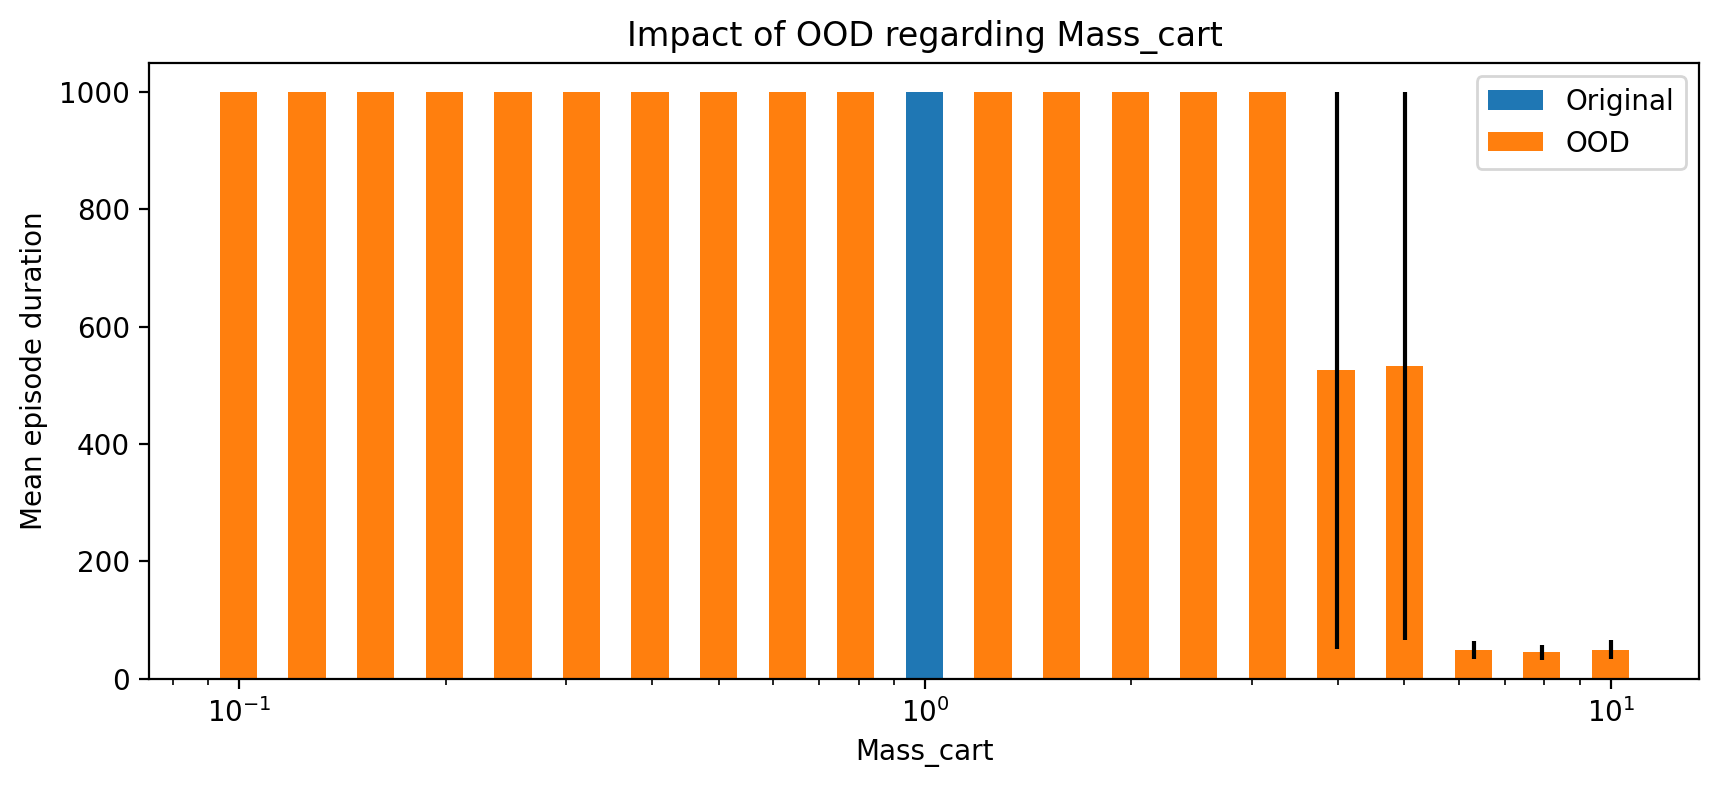

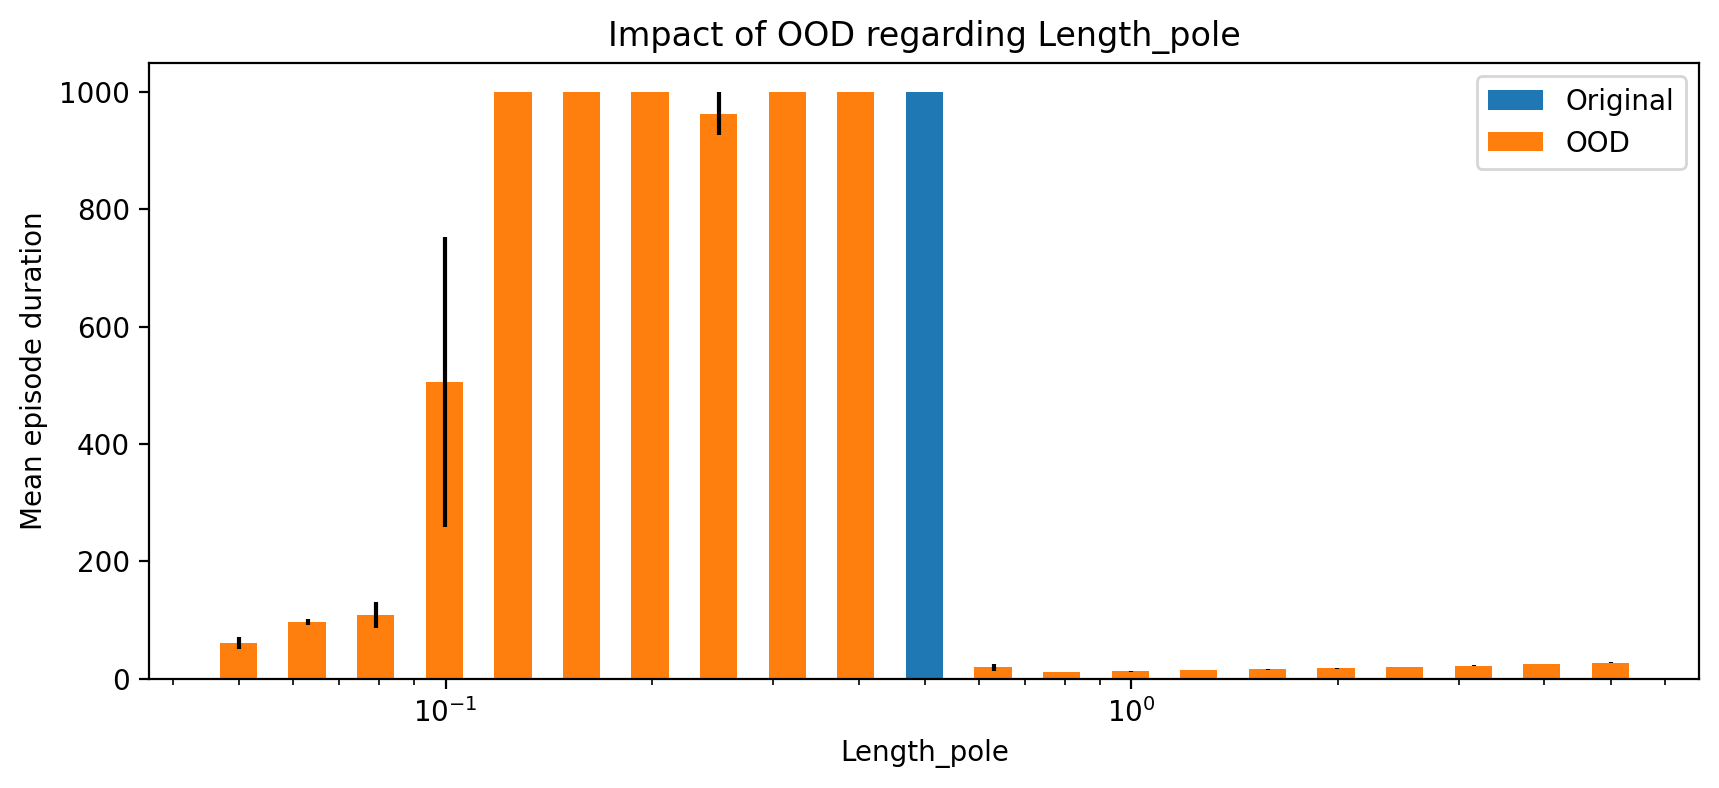

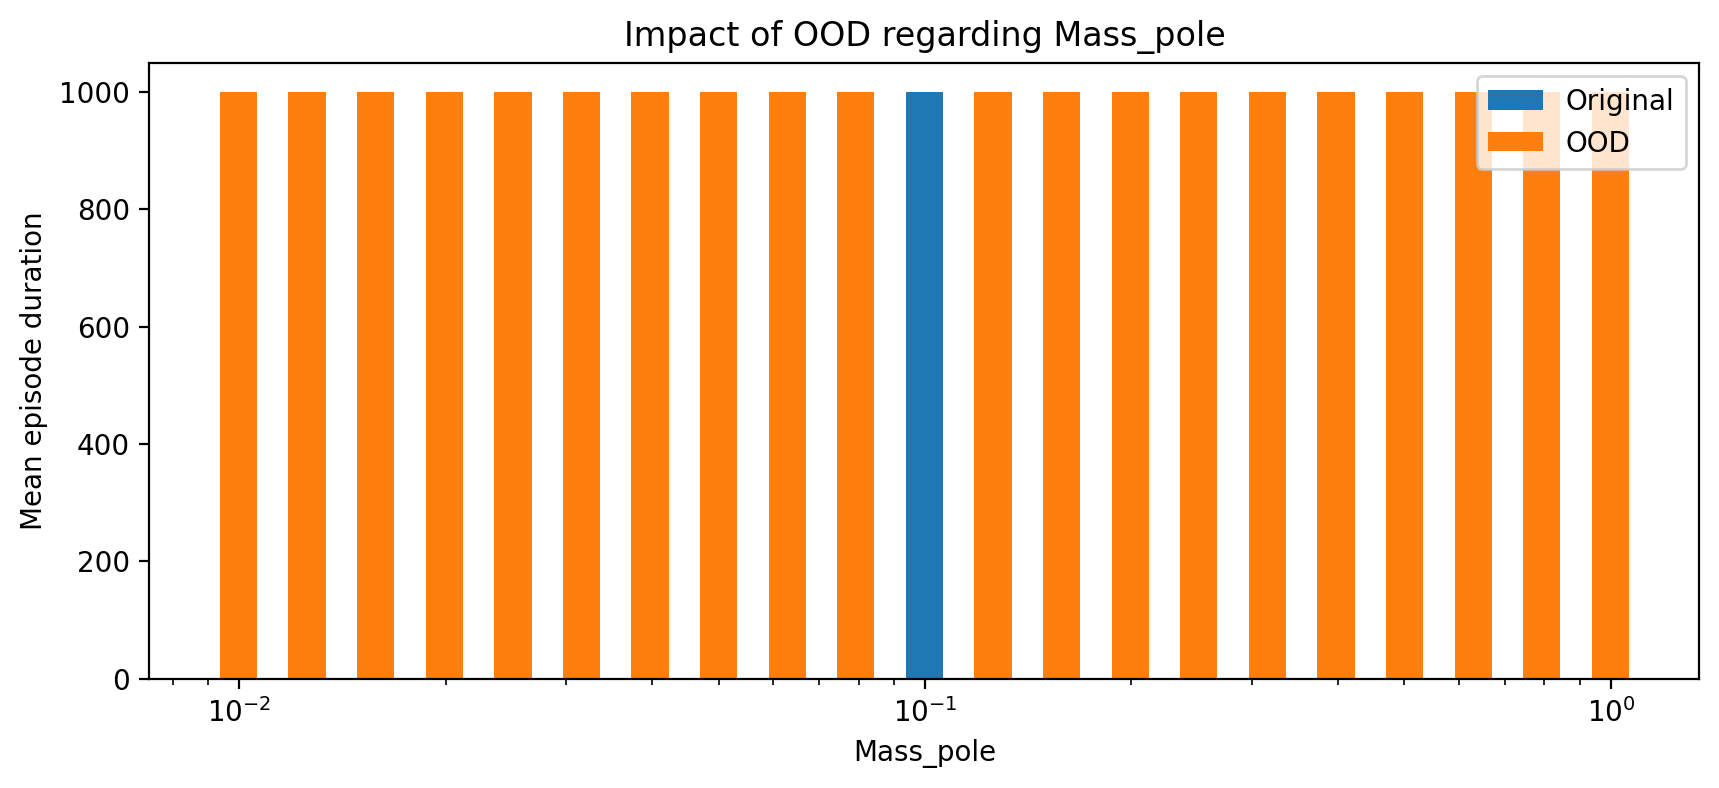

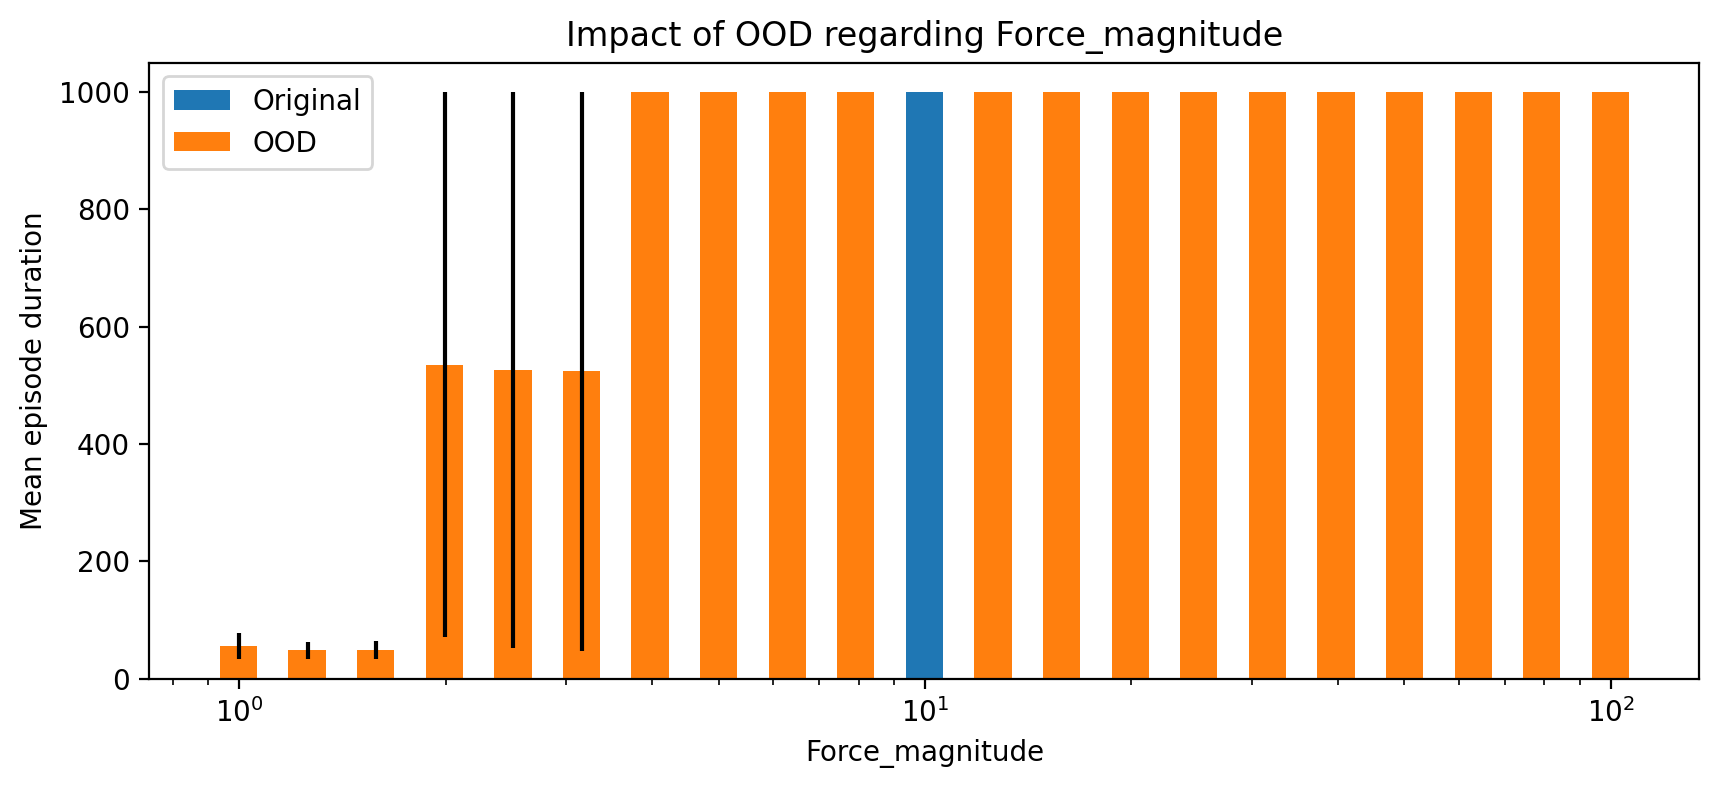

In [37]:
for key in results:
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    
    default_width = default_values[key]/8.0
    width = default_width * np.delete(np.logspace(-1, 1, num=21), 10)
    #np.array([2**i for i in range(-5, 0)] + [2**i for i in range(1, 5+1)])

    ax.bar(default_values[key], original_result, yerr=original_std_result, width=default_width, label='Original')
    ax.bar(values[key], results[key], yerr=std_results[key], width=width, label='OOD')
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)
    ax.legend()
    

# Create OOD detector

The configuration ood detector is relative to its default environment

In [ ]:
env = instanciation_function(default_values)
ood_detector = MartingaleOODDetector(env, verbose=False)
print("Config", default_values)
print("In distrib OOD score:", ood_detector.get_in_distrib_score())

Config {'Gravity': 9.8, 'Mass_cart': 1.0, 'Length_pole': 0.5, 'Mass_pole': 0.1, 'Force_magnitude': 10.0}
In distrib OOD score: 0.2529028316537392


We have a low ood score on the delaut environment

It should be higher on ood environment

In [ ]:
ood_config = get_ood_configs(default_values, values)[9]
ood_env = instanciation_function(ood_config)
print("Config", default_values)
print("OOD score:", ood_detector.test_ood(ood_env, nb_steps=100))

Config {'Gravity': 9.8, 'Mass_cart': 1.0, 'Length_pole': 0.5, 'Mass_pole': 0.1, 'Force_magnitude': 10.0}
OOD score: 0.29689516505453534


Let's compute the ood scores of the previously studies ood environments

In [16]:
mean_ood_scores = {}
std_ood_scores = {}

original_env = instanciation_function(default_values)
agent = A2C.load(path_agent, env=original_env)
ood_detector = MartingaleOODDetector(env)
in_distrib_score = ood_detector.get_in_distrib_score()

for config in tqdm(ood_configs):
    if config['change'] not in mean_ood_scores:
        mean_ood_scores[config['change']] = []
        std_ood_scores[config['change']] = []
    
    ood_env = instanciation_function(config)
    agent = A2C.load(path_agent, env=ood_env)
    list_scores = np.array([ood_detector.test_ood(ood_env, nb_steps=100) for _ in range(10)])
    ood_score = list_scores.mean()
    std_score = list_scores.std()

    mean_ood_scores[config['change']].append(ood_score)
    std_ood_scores[config['change']].append(std_score)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


  0%|          | 0/100 [00:00<?, ?it/s]

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

We now realise a plot of the mean reward and ood scores of each environment. The ones of the delaut environment are in darker colour at the middle of the plot.

  0%|          | 0/5 [00:00<?, ?it/s]

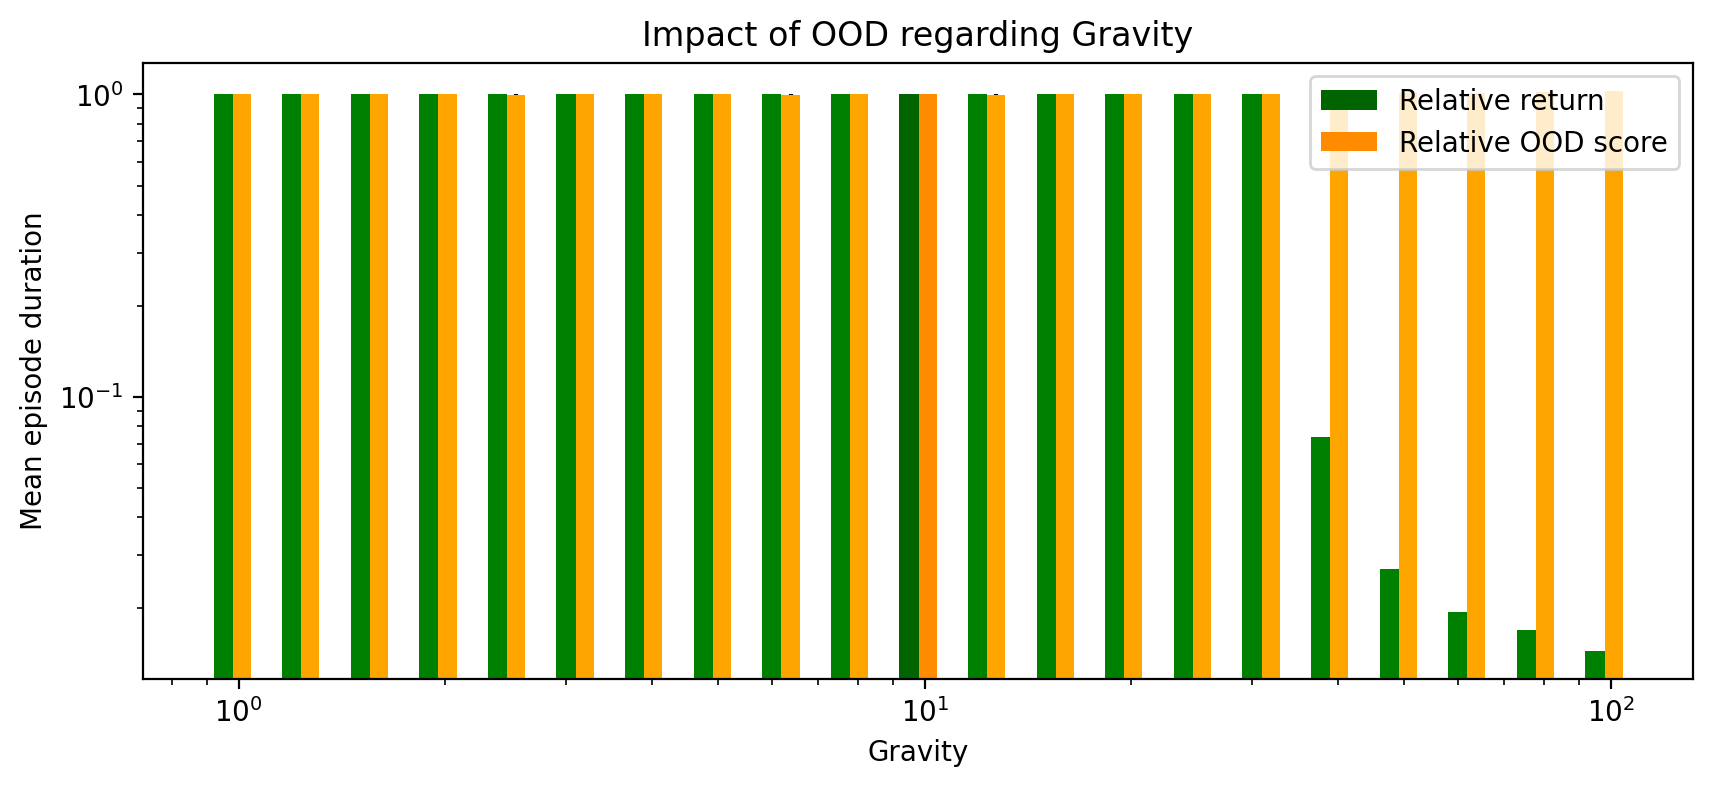

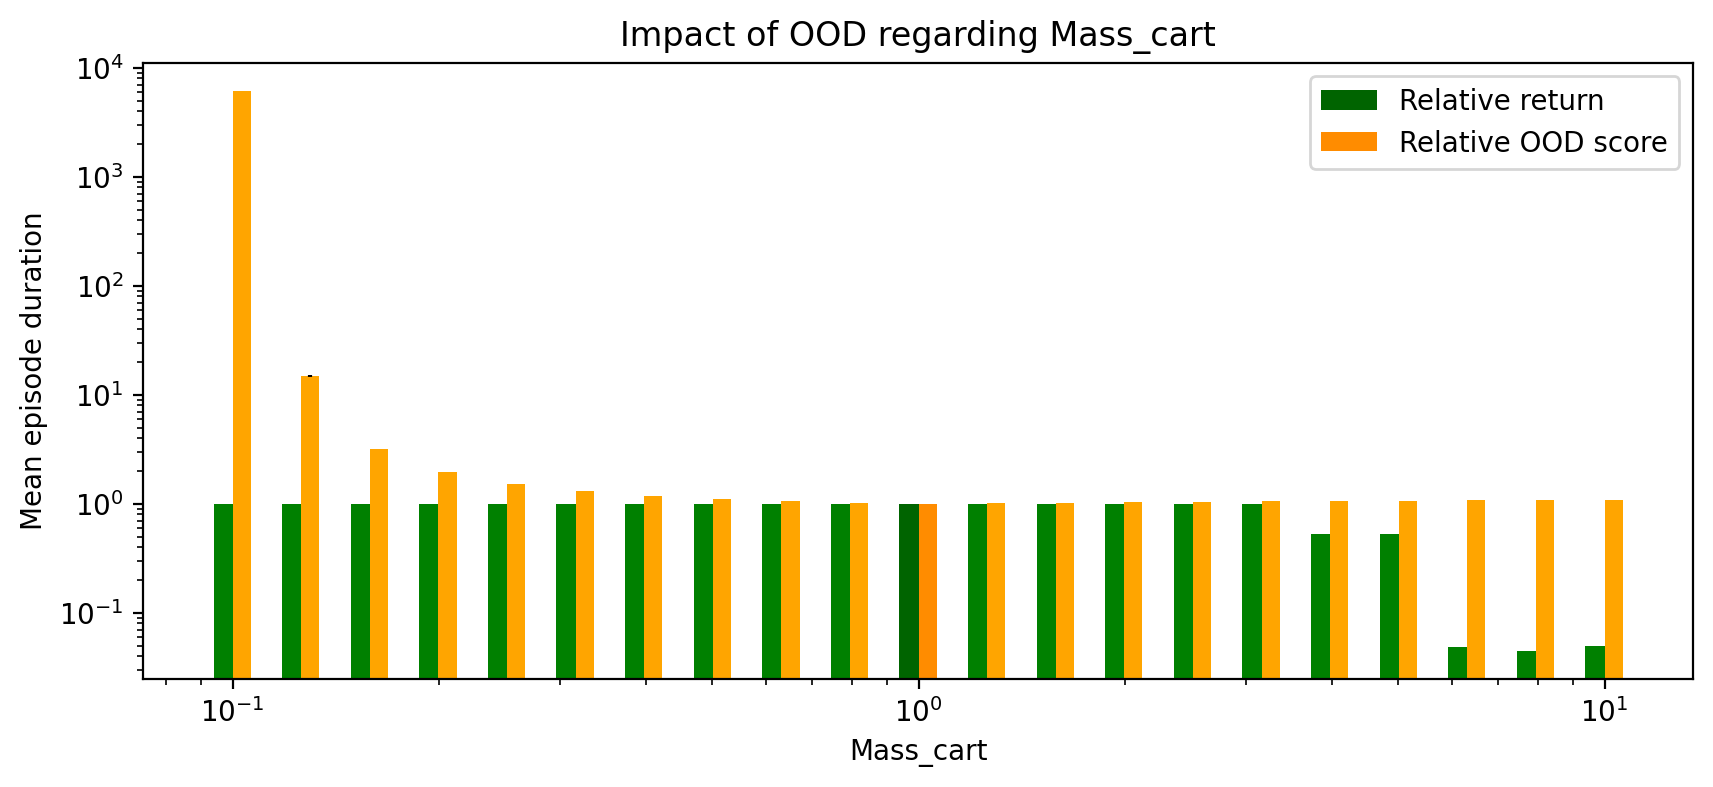

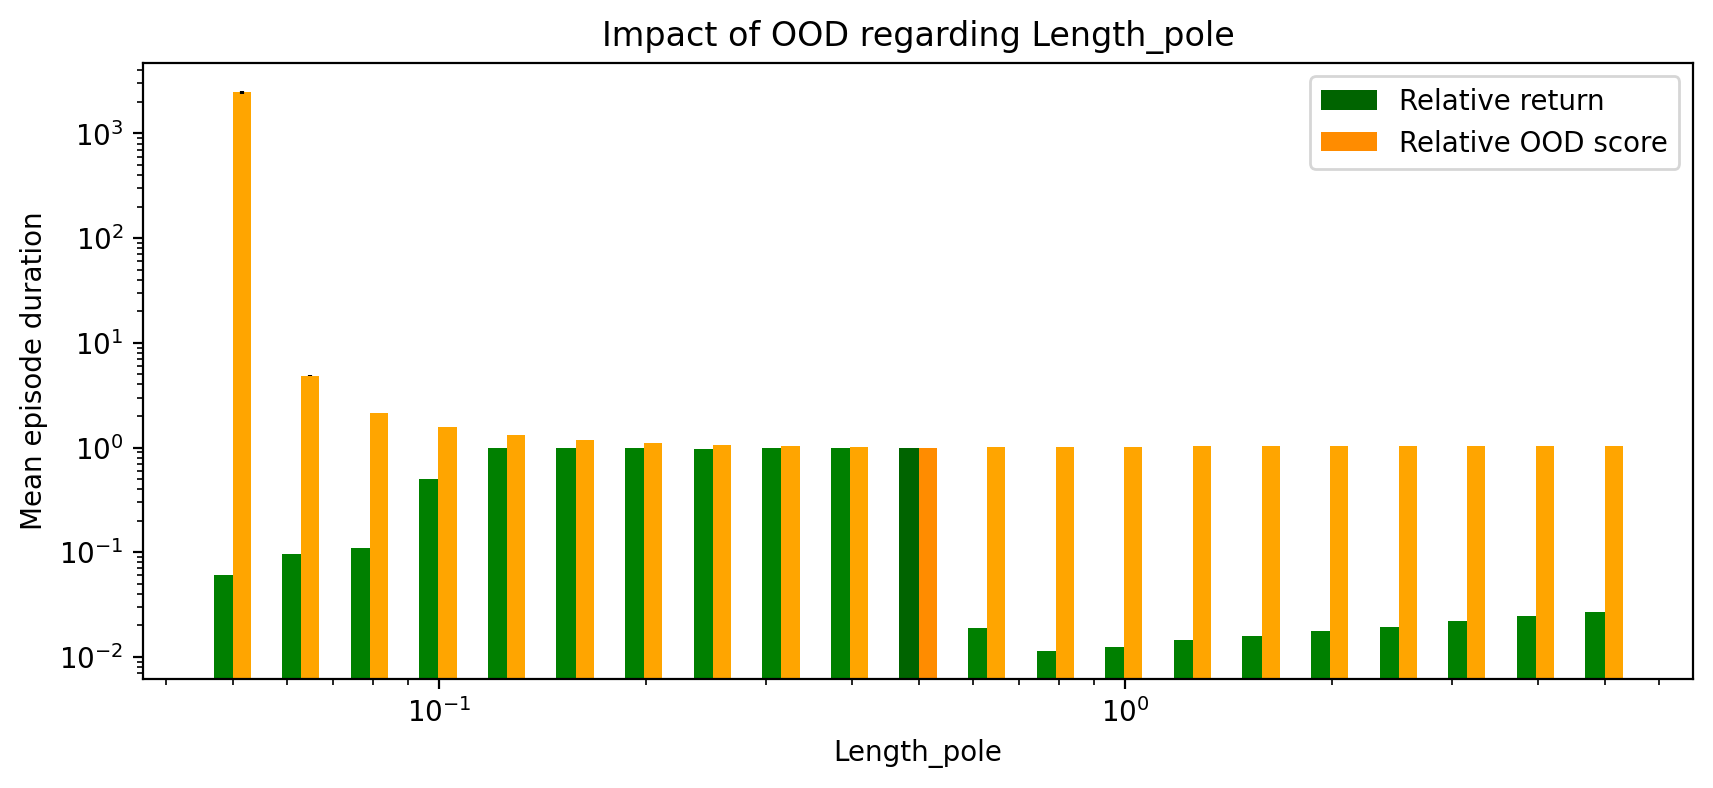

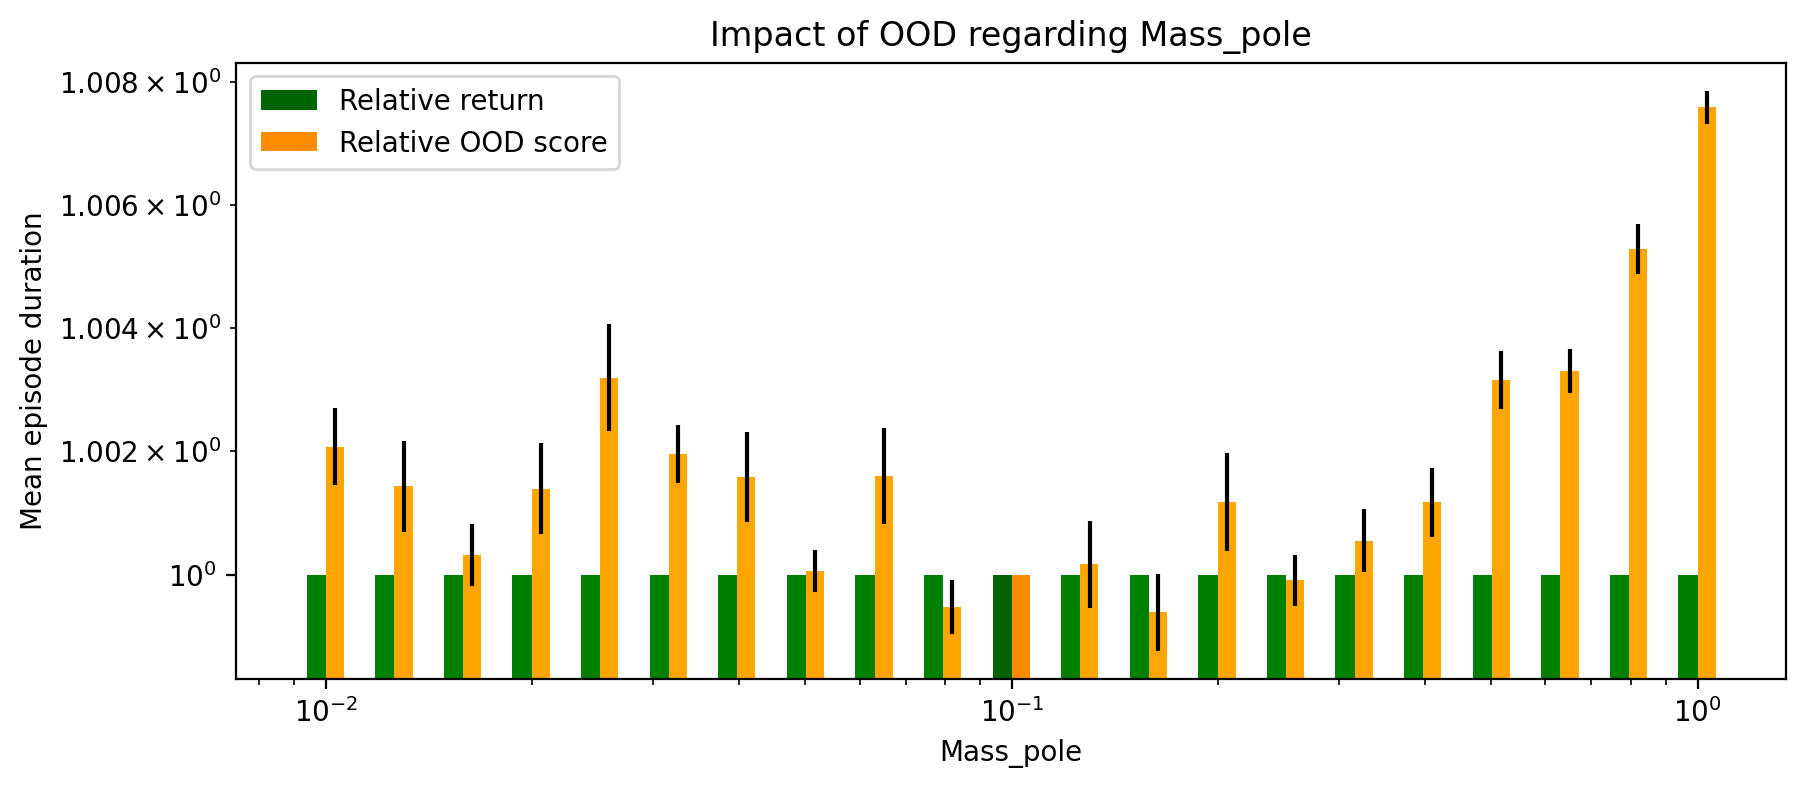

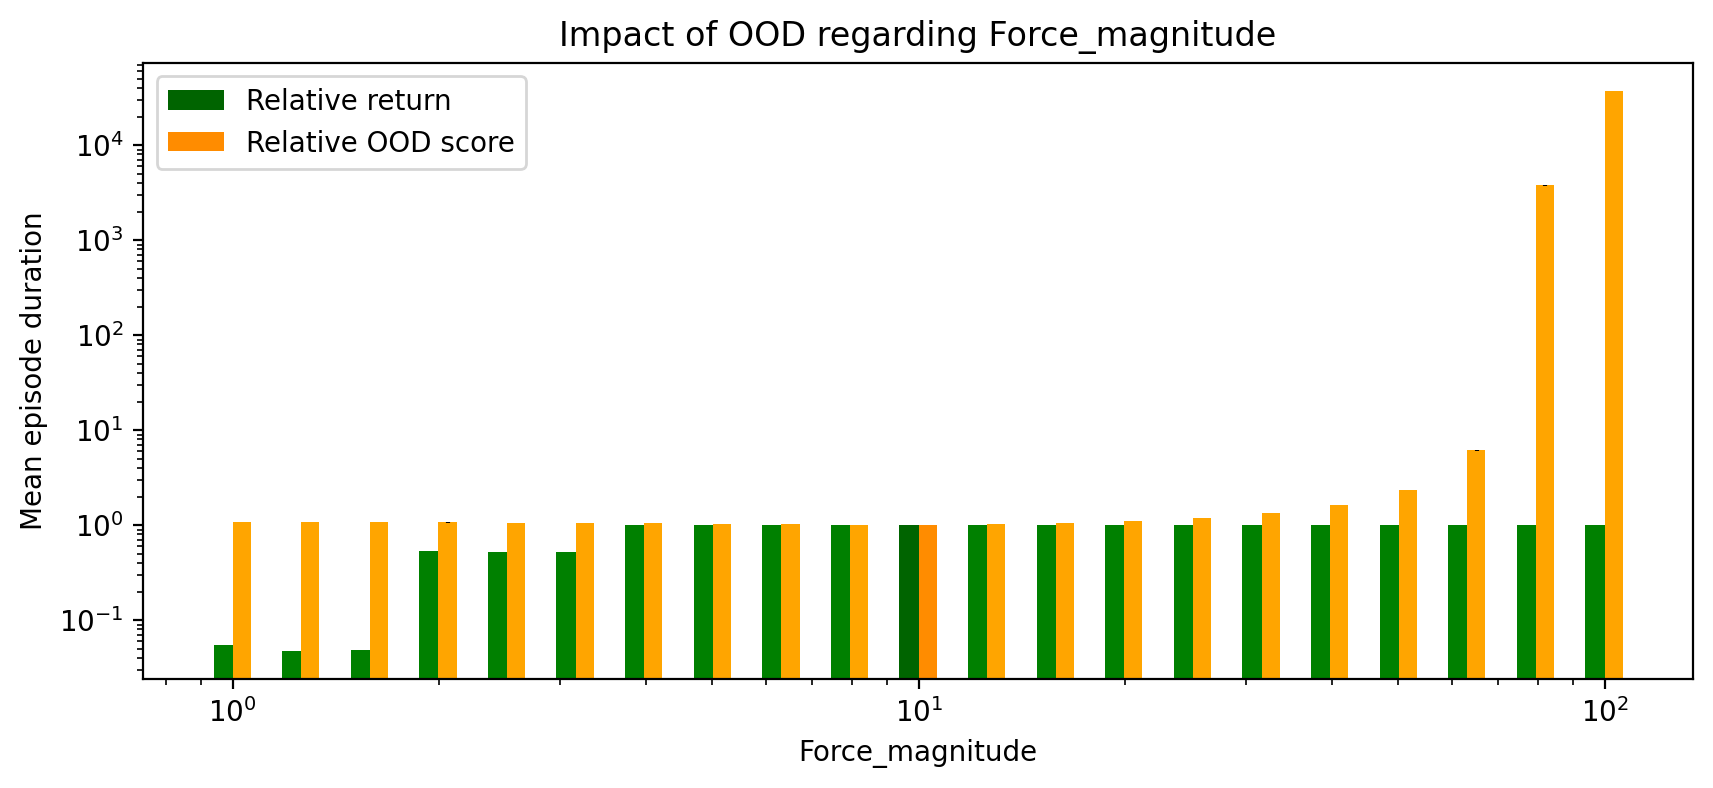

In [39]:
from turtle import color
from numpy import inf


for key in tqdm(results):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    #default_width = default_values[key]/8.0
    #mean_ood_scores[key] = np.nan_to_num(mean_ood_scores[key], copy=True, nan=0.0, posinf=max(mean_ood_scores[key]), neginf=0)
    #std_ood_scores[key] = np.nan_to_num(std_ood_scores[key], copy=True, nan=0.0, posinf=max(std_ood_scores[key]), neginf=0)

    default_width = default_values[key]/8.0
    width = default_width * np.delete(np.logspace(-1, 1, num=21), 10)

    ax.bar(default_values[key]- default_width/4, 1.0, width=default_width/2, label='Relative return', color='darkgreen')
    ax.bar(values[key]- width/4, results[key]/original_result, width=width/2,  color='green')

    ax.bar(default_values[key]+default_width/4, 1.0, width=default_width/2, label='Relative OOD score', color='darkorange')
    ax.bar(values[key]+ width/4, mean_ood_scores[key]/in_distrib_score, width=width/2, color='orange', yerr=std_ood_scores[key])
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)

    plt.legend() #prop={'size': 'medium'}, ncol=2)
   

We add as maning in distribution examples and there are ood examples

In [40]:
original_env = instanciation_function(default_values)
agent = A2C.load(path_agent, env=original_env)

list_scores = []
for _ in trange(5*18):
    list_scores.append(np.array([ood_detector.test_ood(original_env, nb_steps=100) for _ in range(10)]).mean())

mean_ood_scores['None'] = list_scores

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


100%|██████████| 90/90 [00:37<00:00,  2.42it/s]


# Detection speed at a fixed threshold

In [43]:
original_env = instanciation_function(default_values)
list_scores = np.array([ood_detector.test_ood(original_env, nb_steps=1000) for _ in range(100)])
ood_score = list_scores.mean()
std_score = list_scores.std()
threshold = ood_score + 10*std_score

ood_score, std_score, threshold

(0.2536888216259829, 0.0002826907305392452, 0.25651572893137536)

In [44]:
np.array([ood_detector.test_ood(original_env, nb_steps=100) for _ in range(100)]) > threshold

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [51]:
ood_detector = MartingaleOODDetector(original_env)

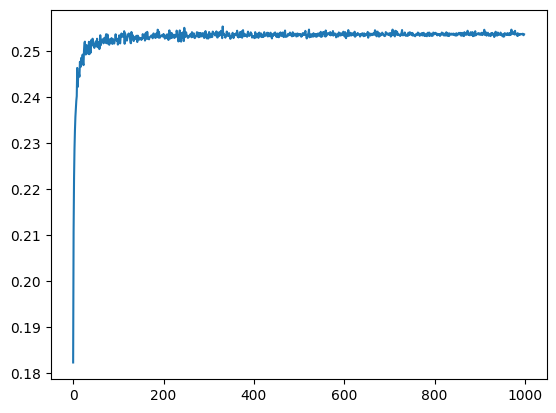

In [47]:
Y = [ood_detector.test_ood(original_env, nb_steps=n) for n in range(1,1000)]
plt.plot(Y)

In [64]:
stop_in_distrib, ood_in_distrib = ood_detector.stop_above_threshold(original_env, threshold, start_at=50, nb_steps=1000)

In [55]:

mean_ood_stops = {}
std_ood_stops = {}

original_env = instanciation_function(default_values)
agent = A2C.load(path_agent, env=original_env)
ood_detector = MartingaleOODDetector(env)


for config in tqdm(ood_configs):
    if config['change'] not in mean_ood_stops:
        mean_ood_stops[config['change']] = []
        std_ood_stops[config['change']] = []
    
    ood_env = instanciation_function(config)
    agent = A2C.load(path_agent, env=ood_env)
    list_stops = np.array([ood_detector.stop_above_threshold(original_env, threshold, start_at=30, nb_steps=1000)[0] for _ in range(10)])
    mean_ood_stop = list_stops.mean()
    std_ood_stop = list_stops.std()

    #mean_reward, std_reward = evaluate(ood_env, agent, nb_episodes=10)

    mean_ood_stops[config['change']].append(mean_ood_stop)
    std_ood_stops[config['change']].append(std_ood_stop)
    #print(config, mean_reward)
    



Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


  0%|          | 0/100 [00:00<?, ?it/s]

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

In [83]:
original_result = 1000.0
stop_in_distrib = 100.0

  0%|          | 0/5 [00:00<?, ?it/s]

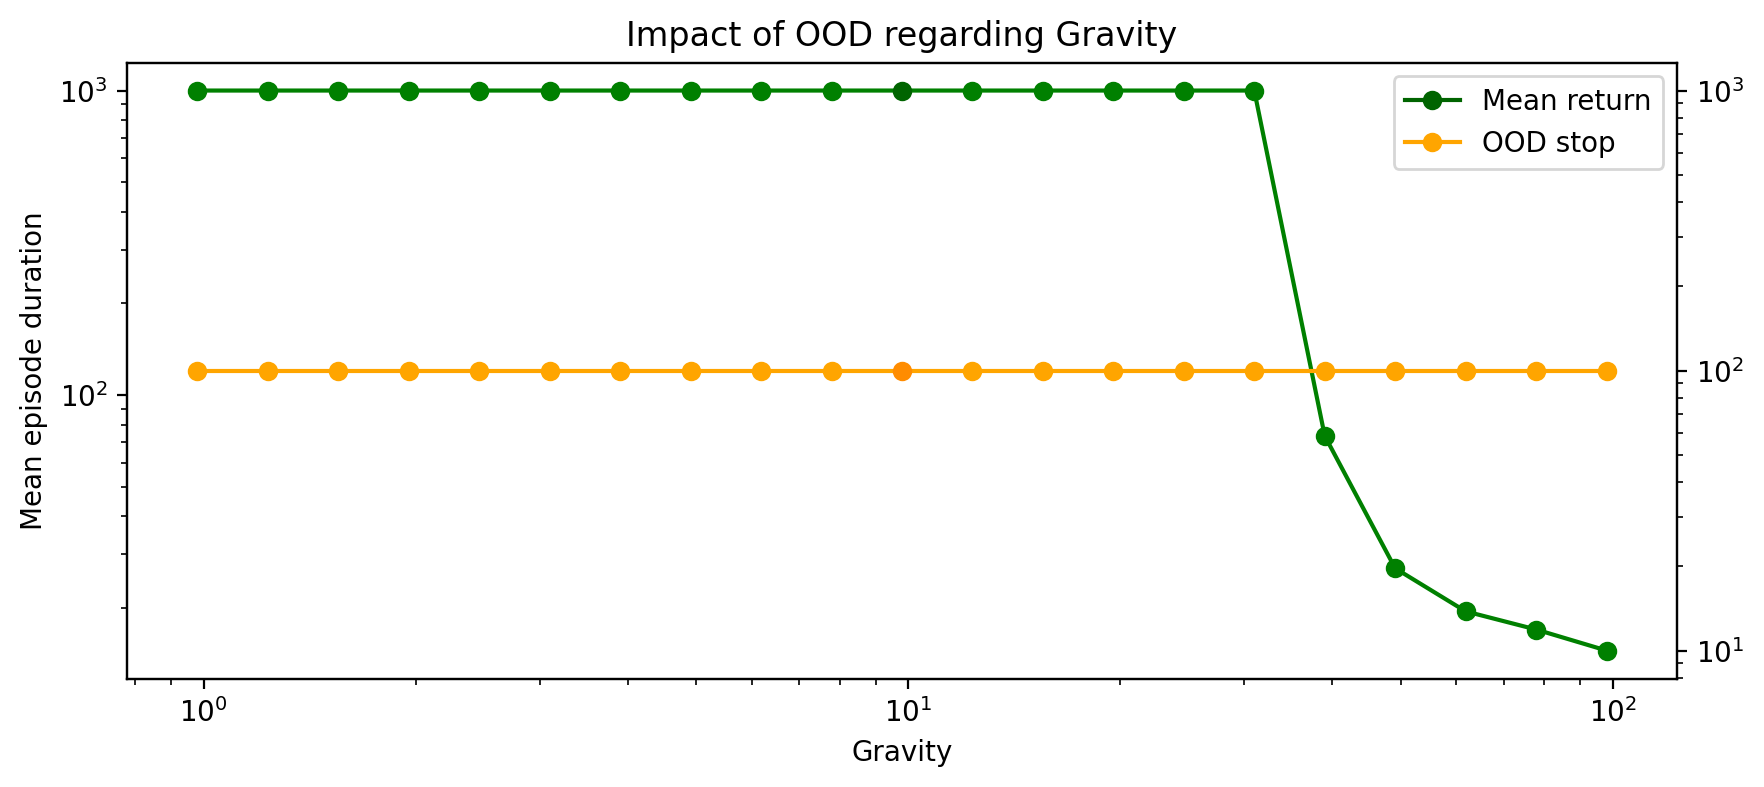

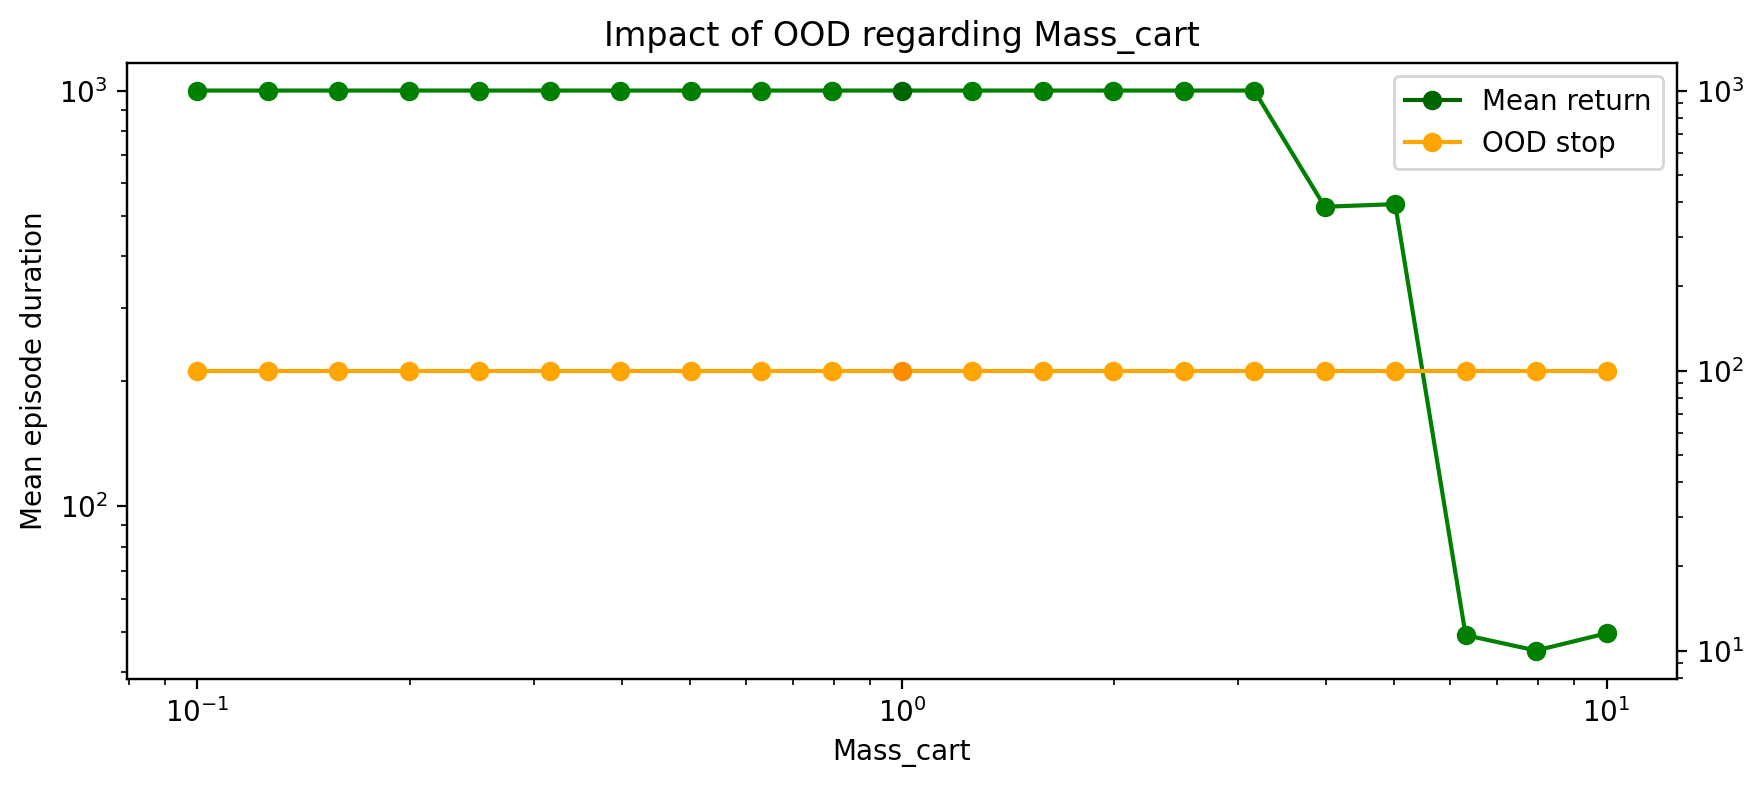

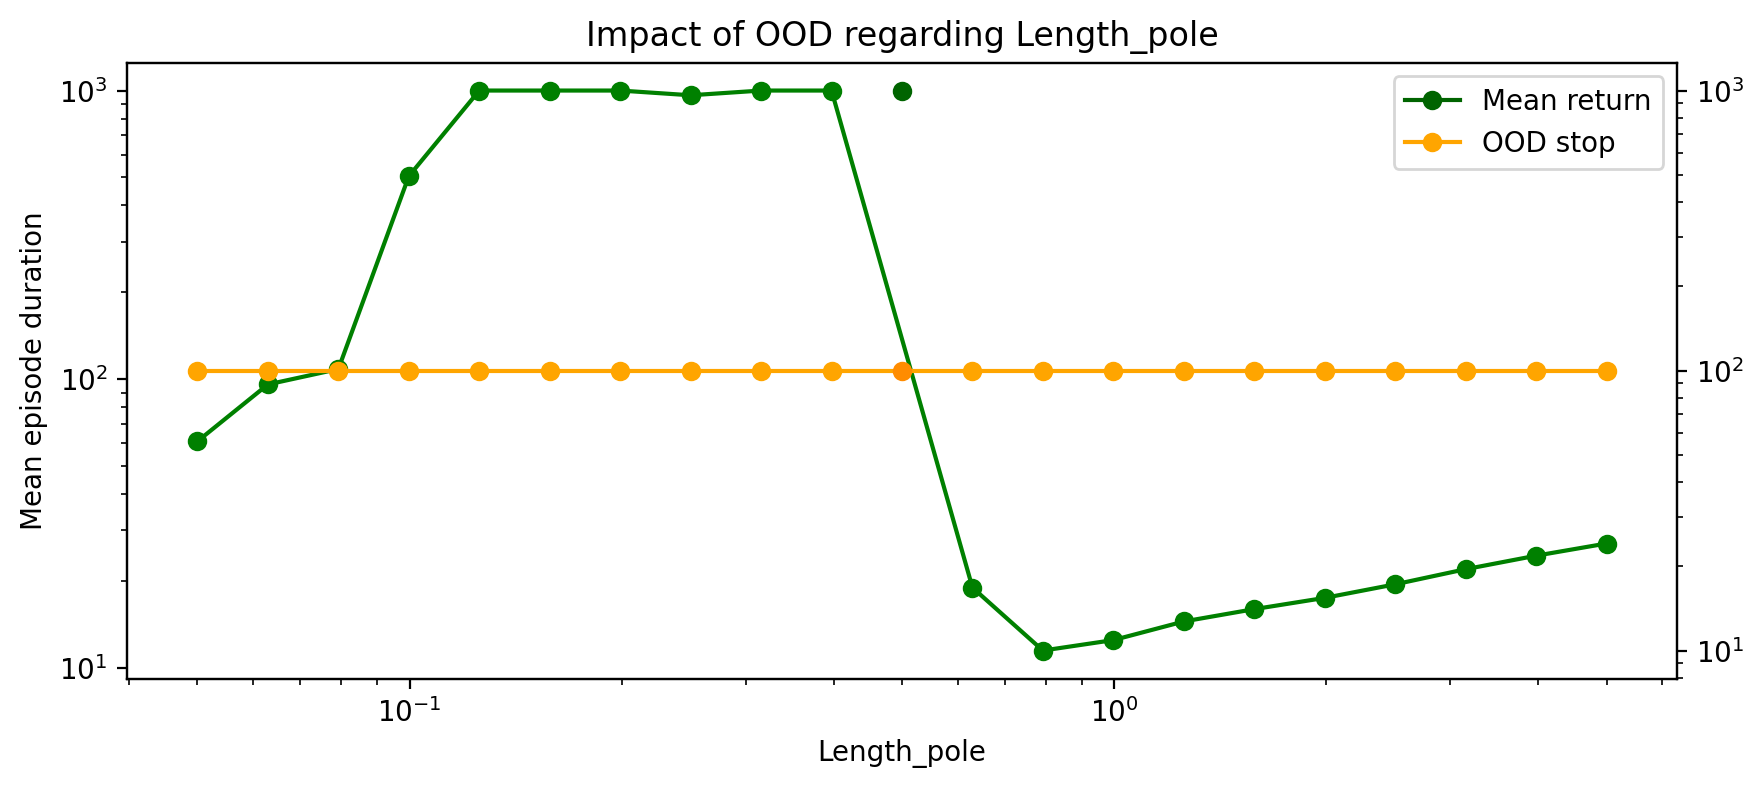

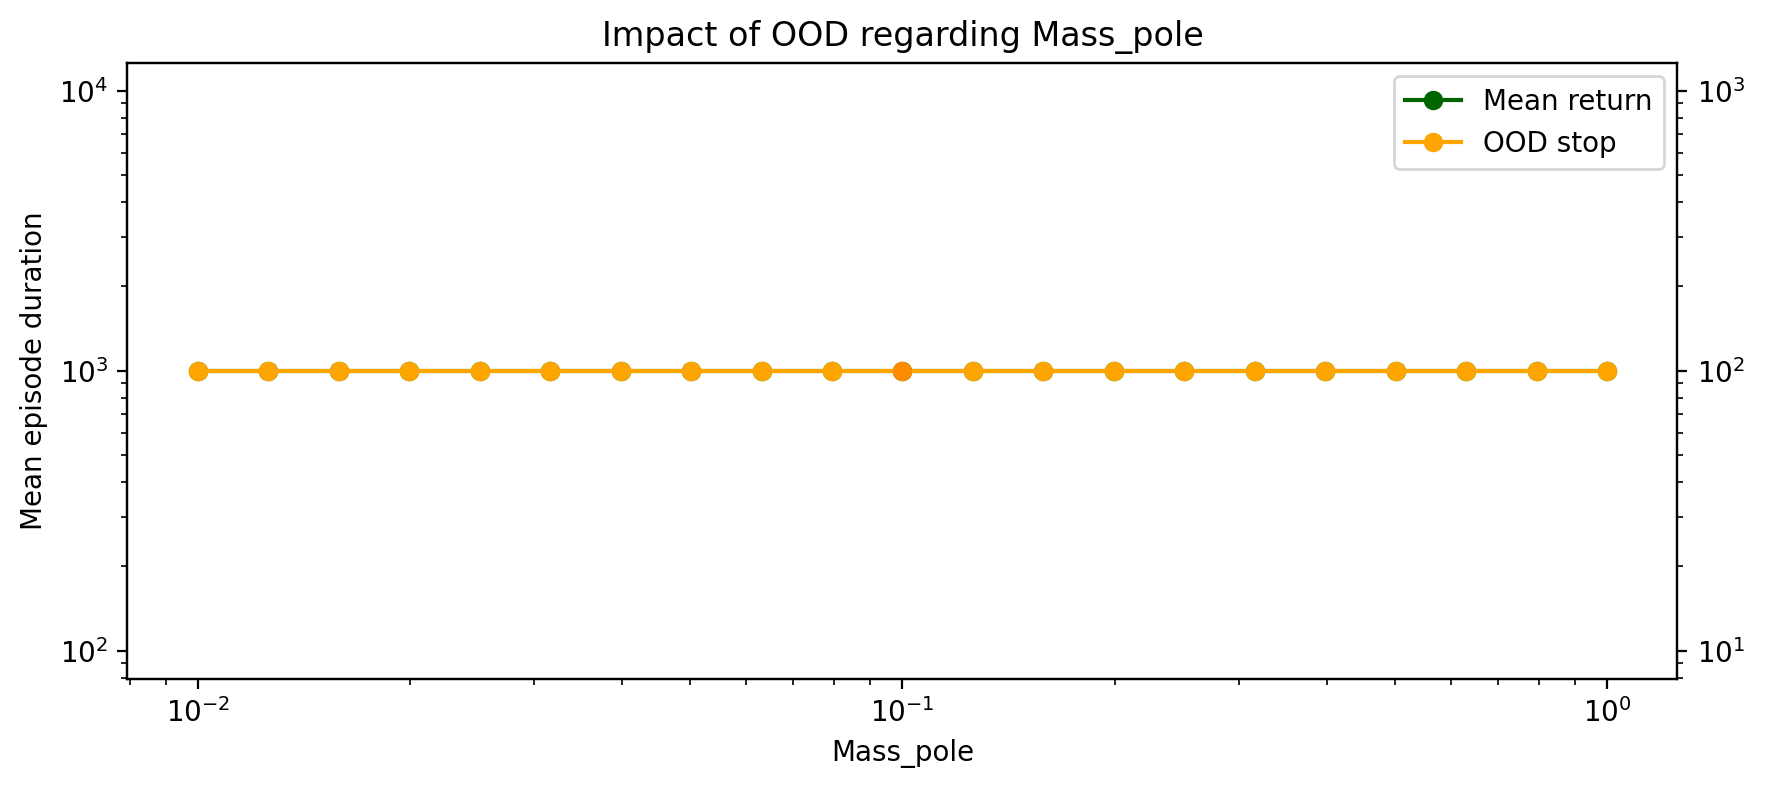

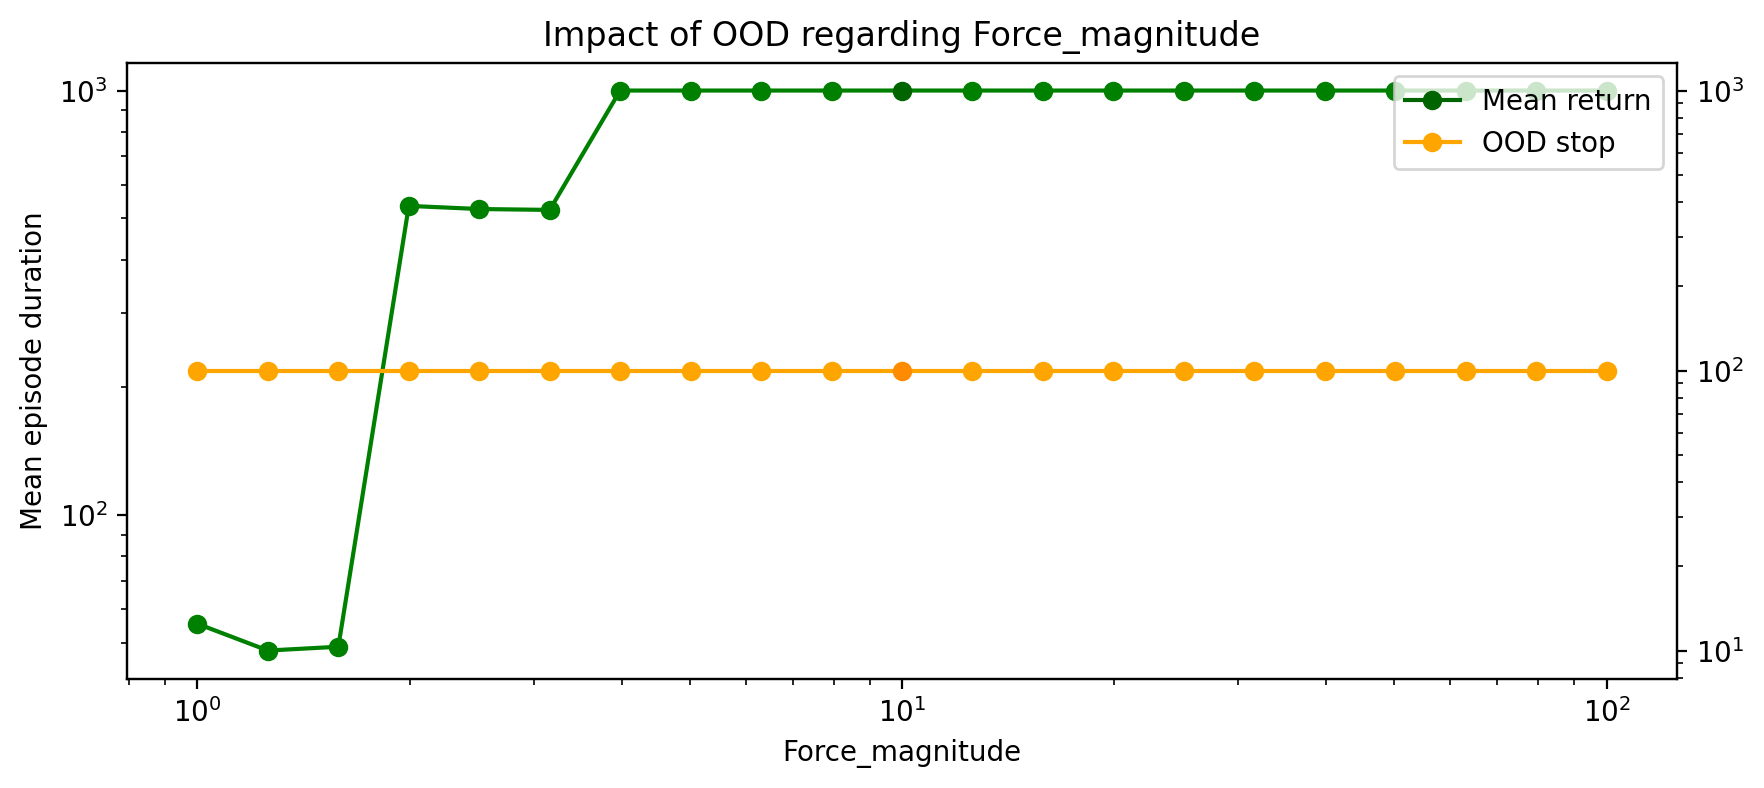

In [84]:
from turtle import color
from numpy import inf


for key in tqdm(results):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax2=ax.twinx()
    ax2.set_yscale('log')
    
    #mean_ood_scores[key] = np.nan_to_num(mean_ood_scores[key], copy=True, nan=0.0, posinf=max(mean_ood_scores[key]), neginf=0)
    #std_ood_scores[key] = np.nan_to_num(std_ood_scores[key], copy=True, nan=0.0, posinf=max(std_ood_scores[key]), neginf=0)

    default_width = default_values[key]/12.0
    width = default_width * np.delete(np.logspace(-1, 1, num=21), 10)
    #print(width, np.array([width[-1]]))
    #width = np.concatenate((width, np.array([width[-1]])))/ 5
    #print(width)

    #ax.bar(default_values[key]- default_width/2, original_result, width=default_width, label='Mean return', color='darkgreen')
    #ax.bar(values[key]- width/2, results[key], width=width,  color='green')

    #ax.bar(default_values[key]+default_width/2, stop_in_distrib, width=default_width, label='OOD stop', color='darkorange')
    #ax.bar(values[key]+ width/2, mean_ood_stops[key], width=width, color='orange', yerr=std_ood_scores[key])
    
    ax.plot(values[key], results[key], label='Mean return', marker='o',color='green')
    ax.plot(default_values[key], original_result, marker='o',color='darkgreen')
    
    ax2.plot([], [], marker='o',color='darkgreen', label='Mean return')
    ax2.plot(values[key], mean_ood_stops[key], label='OOD stop', marker='o',color='orange')
    ax2.plot(default_values[key], stop_in_distrib,  marker='o',color='darkorange')
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)

    plt.legend() #prop={'size': 'medium'}, ncol=2)
   

# Computation of the AUC score

In [ ]:
def compute_AUC(mean_ood_scores, plot=True, verbose=False):
    TPRs = []
    FPRs = []

    thresholds = [10**(-i/10) for i in range(-50, 50+1)]
    for threshold in thresholds:
        false_pos=0
        false_neg=0
        true_pos=0
        true_neg=0

        for key in mean_ood_scores:
            if str(key) != 'None': # Env OOD
                for test_res in mean_ood_scores[key]:

                    if test_res<threshold: # Not detected as OOD
                        false_neg +=1
                    else:
                        true_pos +=1
            else: # Env standard
                for test_res in mean_ood_scores[key]:

                    if test_res>threshold: # Detected as OOD
                        false_pos +=1
                    else:
                        true_neg +=1


        try:
            tpr = true_pos/(true_pos+false_neg)
        except ZeroDivisionError:
            print('error computing tpr')
            continue
            tpr = 1.0
        
        try:
            fpr = false_pos/(false_pos+true_neg)
        except ZeroDivisionError:
            print('error computing fpr')
            continue

        if verbose:
            print(threshold)
            print('TP', true_pos, 'FP',false_pos)
            print('FN', false_neg, 'TN',true_neg)
            print()
            print(tpr, fpr)
        TPRs.append(tpr)
        FPRs.append(fpr)
        #AUC += tpr/len(thresholds)

    if verbose:
        plt.title("TPR and FPR curves")
        plt.plot(TPRs, label='TPR')
        plt.plot(FPRs, label='FPR')
        plt.legend()
        plt.show()
        
    #print('AUC: ', AUC)
    plt.title("ROC curve")
    plt.plot(FPRs, TPRs,'-*')
    plt.xlabel('TPR')
    plt.ylabel('FPR')
    plt.show()

    AUC = integrate.simps(x=FPRs, y=TPRs, even='avg')
    return AUC

In [ ]:
compute_AUC(mean_ood_scores)